In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
mp_key = "bw9PJDXW6ljZz8DyLmXT49ZnMengQUwm"
mp_id = "mp-30460"

In [3]:
with MPRester(mp_key) as m:
    #récupération de la structure
    struct = m.get_structure_by_material_id(mp_id)
    #récupération de la densité d'états de phonons
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

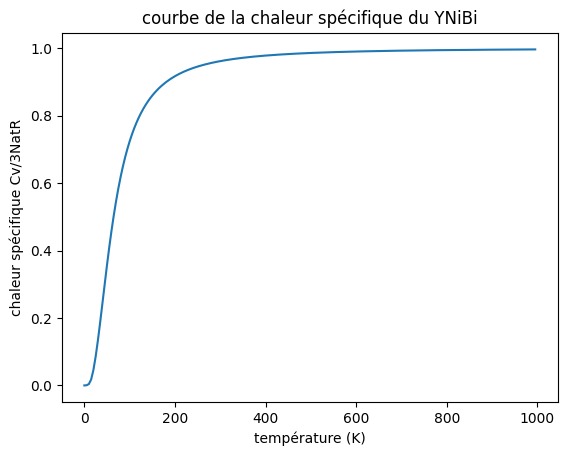

In [4]:
#température spécifique 
temperatures = np.arange(0,1000,5)
R = 8.314
Nat = len(struct)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*Nat*R)

#courbe de la chaleur spécifique du silicium
plt.plot(temperatures, ph_cv)
plt.title('courbe de la chaleur spécifique du YNiBi')
plt.xlabel('température (K)')
plt.ylabel('chaleur spécifique Cv/3NatR')
plt.show()

Température d'Einstein : 192 K


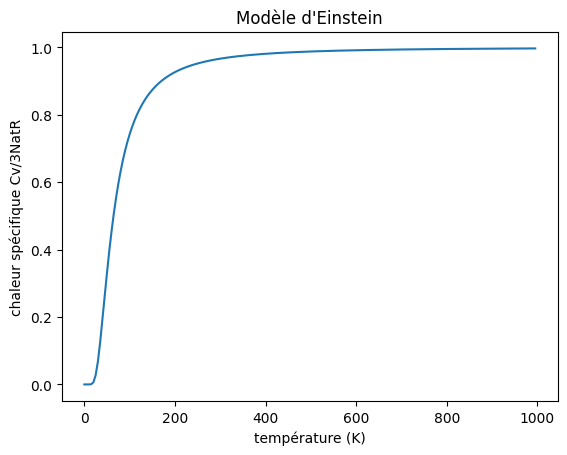

In [5]:
#modèle eintein
def modele_einstein(e, T):
    cv_pred= ((e/T)**2) * np.exp(e/T) / ((np.exp(e/T) - 1) ** 2)
    return cv_pred

erreur_minim_e = 0
t_opt_e = 1
for i in range(1,1000):
    erreur = 0
    for j in range(1,200):
        cv_pred = modele_einstein(i, temperatures[j])
        a = (cv_pred - ph_cv[j])**2
        erreur += a
    if i==1:
        erreur_minim_e = erreur
    if erreur < erreur_minim_e:
        erreur_minim_e = erreur
        t_opt_e = i
print("Température d'Einstein :",t_opt_e,"K")

cv_einstein =[temperatures[0]]
for i in range(1,200):
    cv_einstein.append(modele_einstein(t_opt_e, temperatures[i]))

plt.plot(temperatures, cv_einstein)
plt.title("Modèle d'Einstein")
plt.xlabel('température (K)')
plt.ylabel('chaleur spécifique Cv/3NatR')
plt.show()

Température de Debye : 260 K


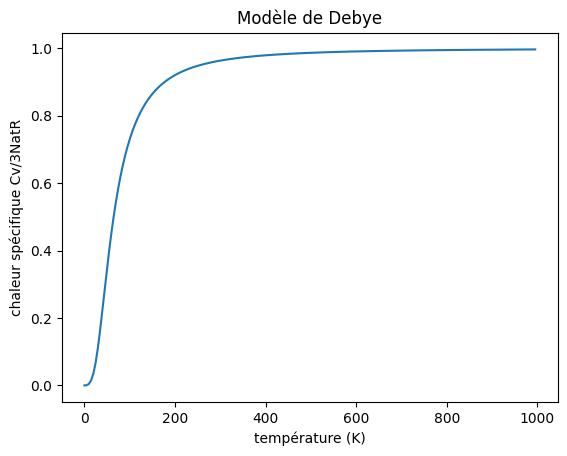

In [6]:
#modèle de debye
def f(x):
    return (x**4) * np.exp(x) / ((np.exp(x) - 1)**2)

def modele_debye(d, T):
    cv_pred = 3*((T/d)**3)*integrate.quad(f, 0, d/T)[0]
    return cv_pred

erreur_minin_d = 0
t_opt_d = 1
for i in range(1,1000):
    erreur = 0
    for j in range(1,200):
        cv_pred = modele_debye(i, temperatures[j])
        a = (cv_pred - ph_cv[j])**2
        erreur += a
    if i==1:
        erreur_minim_d = erreur
    if erreur < erreur_minim_d:
        erreur_minim_d = erreur
        t_opt_d = i
print("Température de Debye :",t_opt_d,"K")

cv_debye=[temperatures[0]]
for i in range(1,200):
    cv_debye.append(modele_debye(t_opt_d, temperatures[i]))

plt.plot(temperatures, cv_debye)
plt.title("Modèle de Debye")
plt.xlabel('température (K)')
plt.ylabel('chaleur spécifique Cv/3NatR')
plt.show()

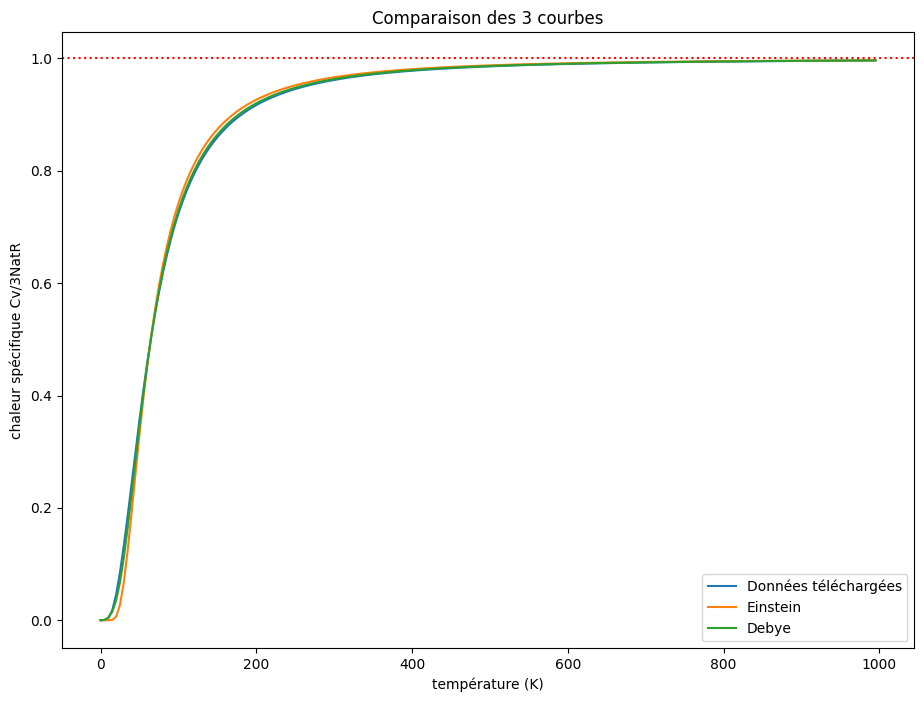

In [7]:
#plot des 3 courbes
plt.figure(figsize=(11, 8))
plt.plot(temperatures, ph_cv, label='Données téléchargées')
plt.plot(temperatures, cv_einstein, label="Einstein")
plt.plot(temperatures, cv_debye, label="Debye")
plt.axhline(y=1, color='red', linestyle= 'dotted')
plt.title('Comparaison des 3 courbes')
plt.xlabel('température (K)')
plt.ylabel('chaleur spécifique Cv/3NatR')
plt.legend()
plt.show()

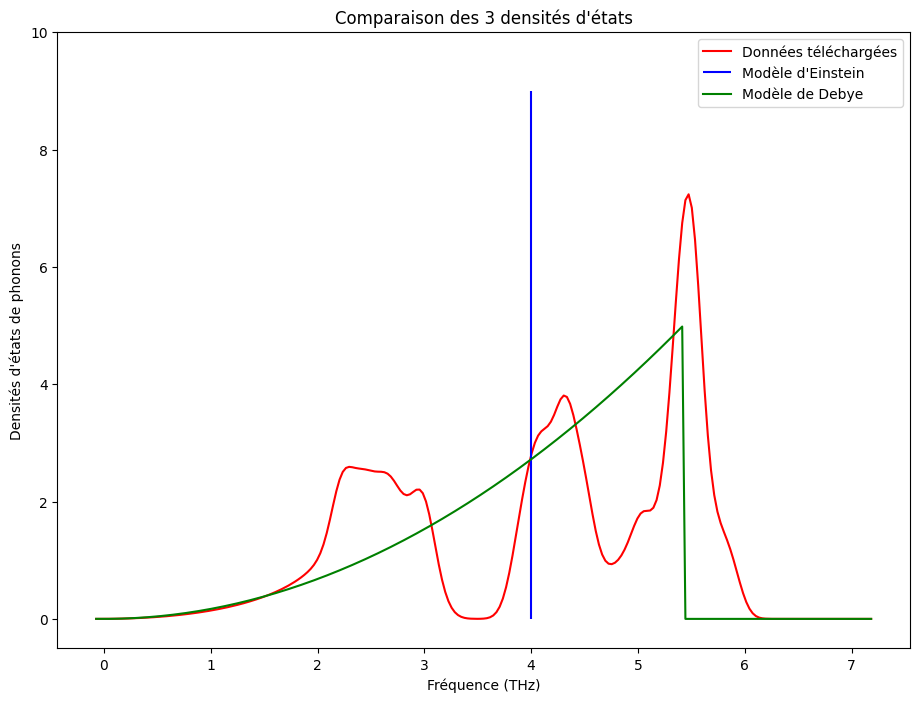

9


In [8]:
#visualisation des 3 densités de phonons
k_B = 1.380649e-23    #J/K
conv_THz = 1e-12
h_barre = 1.055e-34   #J.s


freq = ph_dos.frequencies 
dens = ph_dos.densities

omega_e = conv_THz * k_B * t_opt_e /h_barre
f_e = omega_e/(2*np.pi)   # w =2 pi f

omega_d = conv_THz * k_B * t_opt_d /h_barre

dens_d = np.zeros(len(freq))
for i,f in enumerate(freq):
    omega = 2*np.pi*f
    if omega < omega_d:
        dens_d[i] = (9*Nat*(omega)**2/(omega_d**3))

plt.figure(figsize=(11, 8))
plt.plot(freq, dens,color = "r", label="Données téléchargées")
plt.vlines(f_e, 0, 3 * Nat ,color ="b", label = "Modèle d'Einstein")  #densité d'états de Debye est un delat de dirac
plt.plot(freq, dens_d*(2*np.pi), color='g', label="Modèle de Debye")
plt.title("Comparaison des 3 densités d'états")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence (THz)")
plt.ylim(-0.5, 10)
plt.legend()
plt.show()
print(3*Nat)